In [1]:
!pip install numpy

In [2]:
!pip install scikit-image

In [3]:
!pip install tensorflow
!pip install scikit-learn

In [4]:
!pip install keras
!pip install setuptools


In [5]:
from tensorflow import keras

In [6]:
import os
import numpy as np
from skimage.io import imread, imsave
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from sklearn.metrics import f1_score

In [21]:


# Path to the folders containing images and masks
image_folder_path = 'C:/Users/gorui/Desktop/BTP/images'
mask_folder_path = 'C:/Users/gorui/Desktop/BTP/masks'
output_folder_path = "C:/Users/gorui/Desktop/BTP/output1"


In [8]:
!pip install imagecodecs
from PIL import Image
import os
import imagecodecs
import os
import tifffile as tiff
from PIL import Image


In [9]:
!pip install tifffile

In [10]:
!pip install imagecodecs

In [11]:
import os
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import tifffile as tiff
import imagecodecs

def load_data(image_folder, mask_folder):
    images = []
    masks = []
    for image_name in os.listdir(image_folder):
        if image_name.endswith('.tiff'):
            image_path = os.path.join(image_folder, image_name)
            mask_name = image_name.replace('.tiff', '.jpg')
            mask_path = os.path.join(mask_folder, mask_name)
            if os.path.exists(mask_path):
                try:
                    # Use imagecodecs to decode the LZW-compressed TIFF image
                    image = imagecodecs.imread(image_path)
                    mask = imread(mask_path, as_gray=True)
                    image = resize(image, (256, 256), anti_aliasing=True)
                    mask = resize(mask, (256, 256), anti_aliasing=True)
                    image = np.expand_dims(image, axis=-1)
                    mask = np.expand_dims(mask, axis=-1)
                    images.append(image)
                    masks.append(mask)
                except Exception as e:
                    print(f'Error loading {image_name}: {str(e)}')
    images = np.array(images)
    masks = np.array(masks)
    return images, masks

images, masks = load_data(image_folder_path, mask_folder_path)
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)


In [12]:
!pip install matplotlib
import matplotlib.pyplot as plt

In [15]:
def unet(pretrained_weights=None, input_size=(256, 256, 4)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    if pretrained_weights:
        model.load_weights(pretrained_weights)

    return model


In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate

def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same', activation='relu')(input_tensor)
    x = Conv2D(num_filters, (3, 3), padding='same', activation='relu')(x)
    return x

def unet_model(input_shape, num_classes):
    inputs = Input(input_shape)
    
    # Downsampling (contracting) path
    conv1 = conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = conv_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # Bottom
    conv5 = conv_block(pool4, 1024)
    
    # Upsampling (expanding) path
    up6 = Concatenate()([UpSampling2D(size=(2, 2))(conv5), conv4])
    conv6 = conv_block(up6, 512)
    
    up7 = Concatenate()([UpSampling2D(size=(2, 2))(conv6), conv3])
    conv7 = conv_block(up7, 256)
    
    up8 = Concatenate()([UpSampling2D(size=(2, 2))(conv7), conv2])
    conv8 = conv_block(up8, 128)
    
    up9 = Concatenate()([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = conv_block(up9, 64)
    
    # Incorporating loss from upsampling into downsampling
    conv1_loss = Conv2D(64, (3, 3), padding='same', activation='relu')(conv1)
    conv2_loss = Conv2D(128, (3, 3), padding='same', activation='relu')(conv2)
    conv3_loss = Conv2D(256, (3, 3), padding='same', activation='relu')(conv3)
    conv4_loss = Conv2D(512, (3, 3), padding='same', activation='relu')(conv4)
    
    # Output
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


input_shape = (256, 256, 3)
num_classes = 2
model = unet_model(input_shape, num_classes)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_23[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_25[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_27[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_28[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_6[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 32, 32,    │  2,359,808 │ conv2d_29[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_30[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_7[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 16, 16,    │  9,438,208 │ conv2d_31[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 32, 32,    │          0 │ conv2d_32[0][0]   │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 32, 32,    │          0 │ up_sampling2d_4[

 Total params: 31,379,010 (119.70 MB)

 Trainable params: 31,379,010 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from tensorflow.keras.optimizers import SGD

In [17]:
model = unet()

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# Train the model
checkpoint = ModelCheckpoint('model.keras', monitor='val_loss', save_best_only=True)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=4, epochs=20, callbacks=[checkpoint])



Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1994s 7s/step - accuracy: 0.6638 - loss: 0.2863 - val_accuracy: 0.6870 - val_loss: 0.1190
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1985s 7s/step - accuracy: 0.6917 - loss: 0.1150 - val_accuracy: 0.6912 - val_loss: 0.1261
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1959s 7s/step - accuracy: 0.6920 - loss: 0.1040 - val_accuracy: 0.6907 - val_loss: 0.1068
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 2064s 7s/step - accuracy: 0.6958 - loss: 0.0937 - val_accuracy: 0.6905 - val_loss: 0.0930
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 2047s 7s/step - accuracy: 0.6959 - loss: 0.0882 - val_accuracy: 0.6914 - val_loss: 0.0879
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1993s 7s/step - accuracy: 0.6950 - loss: 0.0848 - val_accuracy: 0.6938 - val_loss: 0.0788
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1985s 7s/step - accuracy: 0.6906 - loss: 0.0865 - val_accuracy: 0.6935 - val_loss: 0.0744
Epoch 8/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1975s 7s/step - accuracy: 0.6972 - loss: 0.0666 - 

In [ ]:
# Save the entire model to a HDF5 file
model.save("model.weights.h5")
# Save only the weights to a HDF5 file
model.save_weights("weight.weights.h5")


In [19]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('model.keras')

In [20]:
def segment_images(model, images):
    segmented_images = model.predict(images)
    return segmented_images

segmented_images = segment_images(model, X_val)


10/10 ━━━━━━━━━━━━━━━━━━━━ 100s 10s/step


In [22]:
for i, image in enumerate(segmented_images):
    imsave(os.path.join(output_folder_path, f'segmented_{i}.tiff'), image.squeeze(), plugin='tifffile')


In [25]:
segmented_images[1]

array([[[1.27142458e-03],
        [7.47709710e-05],
        [7.23781750e-06],
        ...,
        [7.21925297e-11],
        [1.47182677e-09],
        [4.48422452e-06]],

       [[3.34786491e-05],
        [4.18275818e-07],
        [2.37113049e-08],
        ...,
        [6.63552262e-14],
        [1.23930358e-12],
        [5.08044984e-09]],

       [[4.48481887e-06],
        [1.55772675e-08],
        [5.59826463e-10],
        ...,
        [1.14292985e-14],
        [5.61605985e-14],
        [1.82445073e-10]],

       ...,

       [[2.91944104e-07],
        [2.53649463e-10],
        [1.60899054e-11],
        ...,
        [2.51002034e-17],
        [2.13335158e-15],
        [4.85521302e-12]],

       [[1.09203290e-06],
        [5.75713144e-10],
        [2.28184797e-11],
        ...,
        [5.45225706e-15],
        [4.40011797e-13],
        [5.74698344e-10]],

       [[4.11854817e-05],
        [5.96840408e-08],
        [2.33687203e-09],
        ...,
        [1.55307243e-11],
        [5.4154

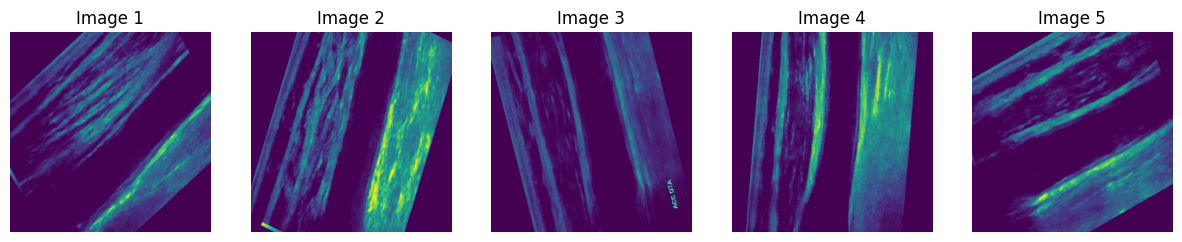

In [32]:
import matplotlib.pyplot as plt

# Assuming X_val is a numpy array containing the validation images
# Plot the first few images from X_val
num_images_to_plot = 5
fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 5))

# Iterate over the first few images in X_val and plot them
for i in range(num_images_to_plot):
    # Assuming the images are in RGB format
    image = X_val[i, :, :, 0]  # Remove the last dimension
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(f'Image {i+1}')

plt.show()



In [23]:
# Calculate F1 score
y_pred = (segmented_images > 0.5).astype(int)
f1 = f1_score(y_val.flatten(), y_pred.flatten())
print(f'F1 Score: {f1}')

ValueError: Classification metrics can't handle a mix of continuous and binary targets

In [27]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

def preprocess_image(image_path, target_size=(256, 256)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [28]:
image_path = 'C:/Users/gorui/Desktop/BTP/testingg/IMG-20240509-WA0001.jpg'
preprocessed_image = preprocess_image(image_path)

In [43]:
X_val.shape

(300, 256, 256, 4, 1)

In [44]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('model.keras')

In [48]:
import os
import numpy as np
from PIL import Image

folder_path = 'C:/Users/gorui/Desktop/BTP/testingg/'

image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

for filename in image_files:
    img_path = os.path.join(folder_path, filename)
    
    img = Image.open(img_path)
    
    img = img.resize((256, 256))
    
    img_array = np.array(img)
    
    if img_array.shape[2] == 3:
        img_array = np.concatenate([img_array, np.zeros((256, 256, 1), dtype=np.uint8)], axis=2)
    
    img = Image.fromarray(img_array).convert('RGB')
    
    save_path = os.path.join('C:/Users/gorui/Desktop/BTP/preprocessed_image_testingg/', filename)
    img.save(save_path)


In [55]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing import image

folder_path = 'C:/Users/gorui/Desktop/BTP/testingg/'

image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

for filename in image_files:
    img_path = os.path.join(folder_path, filename)
    
    img = Image.open(img_path)
    
    img = img.convert('RGBA')

    img = img.resize((256, 256))
    
    img_array = np.array(img)
    
    img_array = img_array / 255.0
    
    if img_array.shape[2] == 3:
        alpha_channel = np.ones((256, 256, 1))
        img_array = np.concatenate([img_array, alpha_channel], axis=-1)
    
    img_array = np.expand_dims(img_array, axis=0)
    
    segmentation_mask = model.predict(img_array)
    
    segmentation_mask = (segmentation_mask > 0.5).astype(np.uint8) * 255
    
    mask_img = Image.fromarray(segmentation_mask[0, :, :, 0], mode='L')
    
    mask_save_path = os.path.join('C:/Users/gorui/Desktop/BTP/output_testingg', filename[:-4] + '_mask.jpg')
    mask_img.save(mask_save_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [4]:
import numpy as np

def dice_coefficient(y_true, y_pred):
    smooth = 1.0
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)




In [ ]:
dice = dice_coefficient(y_true, y_pred)
print("Dice coefficient:",dice)